# Reading IAEA phase space

The international Atomic Energy Agency (IAEA) maintains a [database of phase spaces](https://www-nds.iaea.org/phsp/photon1/) from different medical accelerators, as described in [this report](https://inis.iaea.org/collection/NCLCollectionStore/_Public/37/073/37073778.pdf?r=1). 

In principle, this is great: a standardised phase space format that everyone can adhere to! 
In reality, this is not so much a format as a loose fraternity of data. This mean it is very difficult to provide standardised methods to read these files; although we provide a DataLoader `Load_IAEA`, it is very likely that this will not work 'out of the box' for arbitrary data, and will require some fine tuning. Therefore, the point of this example is to demonstrate the process you would go through to read an IAEA phase space file into this code.

## The IAEA format

All IAEA phase spaces consist of two files:

1. A header file, which is ASCII (human readable) encoded. This contains a lot of information, some of which is essential to how to read the second file:
2. The phasespace file (typical extension `.phsp` of `.IAEAphsp`. This is a file in binary format: to read it correctly, we need to understand exactly what order different quantities are described and how many bytes of data are used to describe them. In principle, such information should be available in the header!

The IAEA report provides the following table describing their phase space format:

![](../docsrc/IAEA_phase_space.png)

However, any of these quantities can also be described as constants, which means that the byte order of an IAEA file is essentially arbitrary.
In principle, it should be possible to dervice this information from the header file, but it's not yet clear to me whether they are consistent enough to always allow that in practice.

## Reading an IAEA phase space file

With all this said, how does one actually go about reading an IAEA phase space?
In this case, I will read in a small section of a variance phase space file which contained the following information in the header:

```
Format of the phase space file:
Type (1 byte); Energy (4 bytes); X position (4); Y position (4); Component of
momentum direction in X (4); Component of momentum direction vector in Y (4)
```

and

```
$RECORD_CONSTANT:
     26.7       // Constant Z
     1.0000     // Constant Weight
```

With these two pieces of information, we can specify the order and types of the data, as well as the constants:

In [1]:
import sys
sys.path.insert(0, '../') # not necessary when code is installed
from ParticlePhaseSpace import PhaseSpace, DataLoaders
from pathlib import Path
import numpy as np

# get data file:
file_name = Path(r'/home/brendan/Dropbox (Sydney Uni)/abstracts,presentations etc/temp/TrueBeam_v2_6X_00.phsp')
# file_name = Path(r'/home/brendan/Downloads/Varian_TrueBeam6MV_01.phsp')
# read in
data_schema = np.dtype([
               ('particle type', 'i1'),
               ('Ek', 'f4'),
               ('x', 'f4'),
               ('y', 'f4'),
               ('Cosine X', 'f4'),
               ('Cosine Y', 'f4')])

constants = {'z': np.float32(26.7), 'weight': np.int8(1)}

ps_data = DataLoaders.Load_IAEA(file_name, n_records=int(1e5), constants=constants, data_schema=data_schema)

/home/brendan/Documents/python/ParticlePhaseSpace/examples/../ParticlePhaseSpace/DataLoaders.py:446: UserWarning: this data has negative energy in it, what does that even mean. forcing all energy to positive
  warnings.warn('this data has negative energy in it, what does that even mean. forcing all energy to positive')


In this case, we were able to figure out the format of the data in the header, and specify this to the data loader.

A few other notes here:

- we specified `n_records=1e5`; this controls how many rows of the data get read in. Since this files can be very large it is not always desirable to read them in one 'chunk'.
- we got a warning about negative energy. As the warning says: the energy in this phase space is negative. I don't know why that is; it physically makes no sense so I force the energy to positive.

Now that we've loaded the data let's take a look at it:

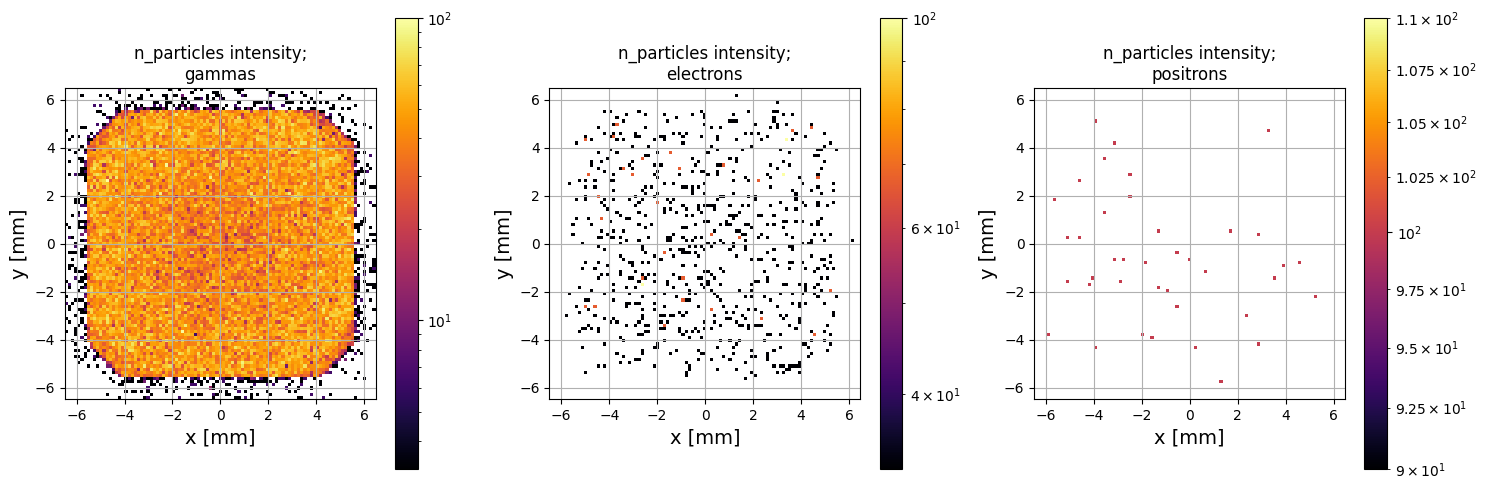

In [2]:
PS = PhaseSpace(ps_data)
# again, because this data can be quite large we can manually delete the loader now we've finished with it
del ps_data
PS.plot.particle_positions_hist_2D(log_scale=True)

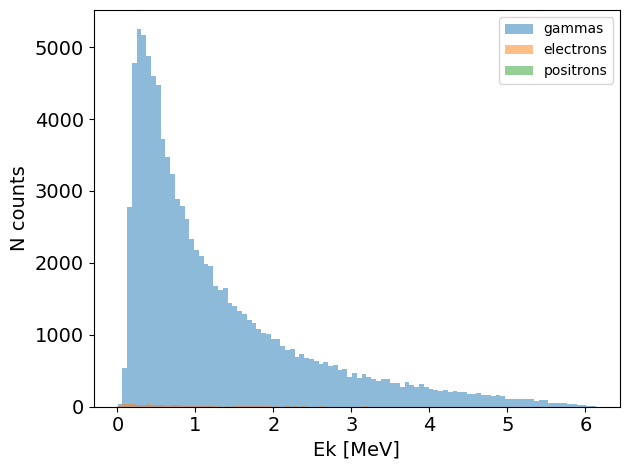

In [3]:
PS.plot.energy_hist_1D()

## When things don't work quite so well...

To take another example; look at the TrueBeam data available on [this database](https://www-nds.iaea.org/phsp/photon1/).

In this instance, the header does not nicely specify what is in the the phase space data, so we have to guess. This is what the header does tell us:

```PERL
$RECORD_CONTENTS:
    1     // X is stored ?
    1     // Y is stored ?
    1     // Z is stored ?
    1     // U is stored ?
    1     // V is stored ?
    1     // W is stored ?
    0     // Weight is stored ?
    0     // Extra floats stored ?
    0     // Extra longs stored ?

$RECORD_CONSTANT:
     1.0000     // Constant Weight
```

Based on this, and the info on IAEA phase space format in the table above, I would guess that the data scheme looks something like this:

In [4]:
data_schema = np.dtype([
                       ('x', 'f4'),
                       ('y', 'f4'),
                       ('z', 'f4'),
                       ('Cosine X', 'f4'),
                       ('Cosine Y', 'f4'),
                       ('Ek', 'f4'),
                       ('particle type', 'i2')])

constants = {'weight': np.int8(1)}

let's see how this goes...

In [5]:
file_name = Path(r'/home/brendan/Downloads/Varian_TrueBeam6MV_01.phsp')
ps_data = DataLoaders.Load_IAEA(file_name, n_records=int(1e5), constants=constants, data_schema=data_schema)

Exception: specified data schema has differeny byte length to that indicated in header.
header specifies 25,
schema specifies 26

So, this is an interesting error. There is a field called `$RECORD_LENGTH` in the header which specifies how many bytes are in each entry of data. Of course, the number of bytes specified by our data_scheme specification should match this, and the code checks that it does before trying anything else.

In this case, it would appear that our specified data scheme is one byte longer than that specified in the header. Now, we know from the previous file that we loaded that varian has been known to use a 1 byte integer instead of a 2 byte integer (as specified by the IAEA, which could explain this discrepancy. So let's try using a 1 byte integer instead:

In [6]:
data_schema = np.dtype([
                       ('x', 'f4'),
                       ('y', 'f4'),
                       ('z', 'f4'),
                       ('Cosine X', 'f4'),
                       ('Cosine Y', 'f4'),
                       ('Ek', 'f4'),
                       ('particle type', 'i1')])

constants = {'weight': np.int8(1)}
ps_data = DataLoaders.Load_IAEA(file_name, n_records=int(1e5), constants=constants, data_schema=data_schema)

TypeError: unknown particle code -74

OK, doing this at least the byte number is correct, but now we have an unidentified type of particle. This indicates that we very likely did not read in the particle type correctly. We also know from last time that varian specified the particle type first; let's try that:

In [7]:
data_schema = np.dtype([
                       ('particle type', 'i1'),
                       ('x', 'f4'),
                       ('y', 'f4'),
                       ('z', 'f4'),
                       ('Cosine X', 'f4'),
                       ('Cosine Y', 'f4'),
                       ('Ek', 'f4'),
                       ])

constants = {'weight': np.int8(1)}

ps_data = DataLoaders.Load_IAEA(file_name, n_records=int(1e5), constants=constants, data_schema=data_schema)

/home/brendan/Documents/python/ParticlePhaseSpace/examples/../ParticlePhaseSpace/DataLoaders.py:446: UserWarning: this data has negative energy in it, what does that even mean. forcing all energy to positive
  warnings.warn('this data has negative energy in it, what does that even mean. forcing all energy to positive')


Exception: failed to calculate momentums from topas data. Possible solution is to increasethe value of momentum_precision_factor, currently set to  1.00e-03and failed data has value  2.71e+01

Getting closer! we read in the particles correctly, but the conversion to momentum failed.

At this point, i basically did a lot of debugging. I was pretty sure that the data consisted of 1 1-byte integer and 6 4-byte floats. I also new for instance what the distribution of energy, x, and y should look like. So basically, I swapped around the order of the columns until all these distributions started to look right, ending up with the following schema:

In [8]:
from ParticlePhaseSpace import PhaseSpace, DataLoaders
from pathlib import Path
import numpy as np

# get data file:
file_name = Path(r'/home/brendan/Dropbox (Sydney Uni)/abstracts,presentations etc/temp/TrueBeam_v2_6X_00.phsp')
file_name = Path(r'/home/brendan/Downloads/Varian_TrueBeam6MV_01.phsp')

data_schema = np.dtype([
                       ('particle type', 'i1'),
                       ('Ek', 'f4'),
                       ('x', 'f4'),
                       ('y', 'f4'),
                       ('z', 'f4'),
                       ('Cosine X', 'f4'),
                       ('Cosine Y', 'f4')
                       ])

constants = {'weight': np.int8(1)}

ps_data = DataLoaders.Load_IAEA(file_name, n_records=int(1e6), constants=constants, data_schema=data_schema)
PS = PhaseSpace(ps_data)

/home/brendan/Documents/python/ParticlePhaseSpace/examples/../ParticlePhaseSpace/DataLoaders.py:467: UserWarning:  1 entries returned invalid pz values and were set to zero.
We will now check that momentum and energy are consistent to within  0.0010 MeV
  warnings.warn(f'{n_negative_locations: d} entries returned invalid pz values and were set to zero.'


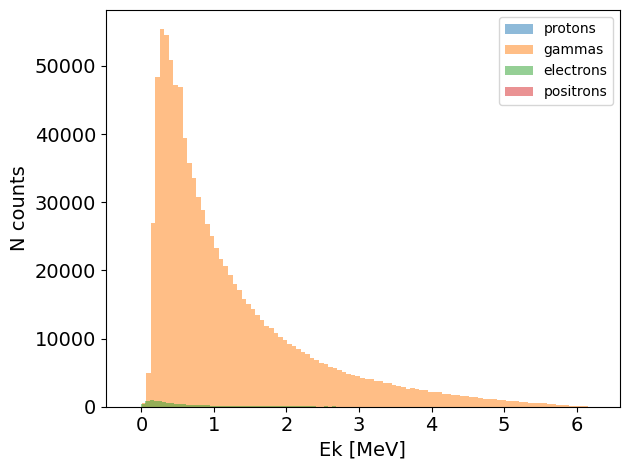

In [9]:
PS.plot.energy_hist_1D()

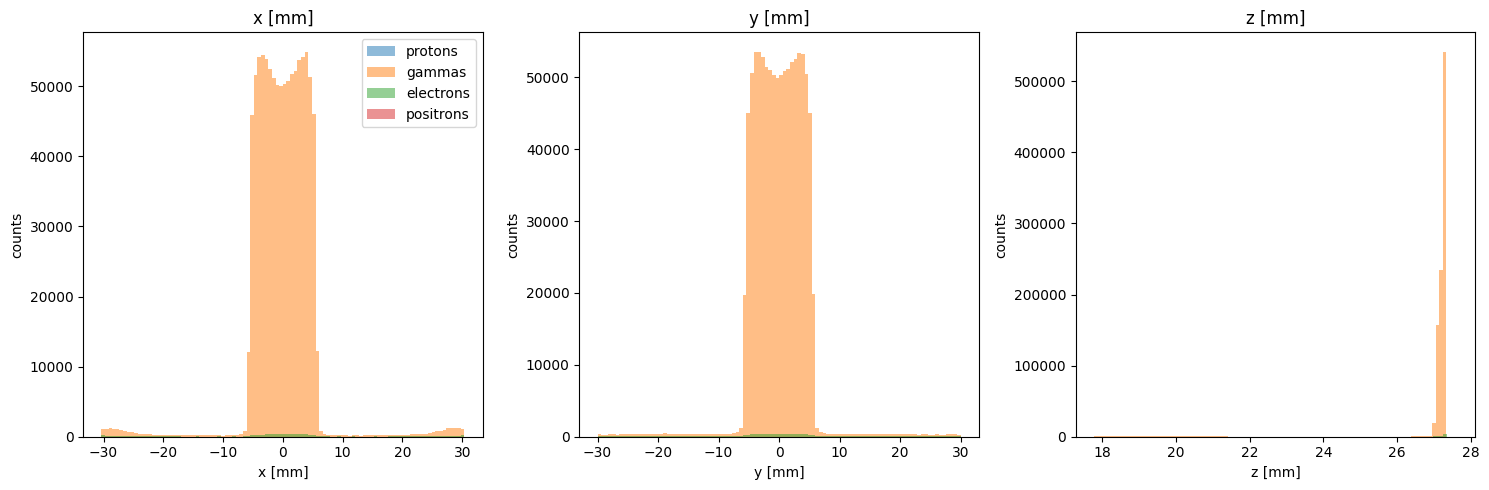

In [10]:
PS.plot.position_hist_1D()

OK, so this read in appears to have worked; all the consistency checks are passing and the data all looks as expected for a 6MV beam.

## Next steps

What would be nice is to be able to develop an automated IAEA phase space reader. However, at this point it appears that the information is frequently ordered in arbitrary ways that are not actually explained in the header. For the most recent data, I only managed to figure out how to read it after a period of trial and error. It really does not appear that files in the IAEA database are following the IAEA format at all...